In [47]:
# ===== Pacotes / Packages =====
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.utils import to_categorical

In [36]:
# ===== Carregar dados .xlsx / Load data .xlsx =====
df = pd.read_excel("NAME.xlsx")
print(df.head())

   Cluster  T.Lic..alim  CNaCl.alim  CNaOH.alim        P3        P2        T3  \
0        2    -0.495287   -0.203292   -0.615942 -0.994538 -1.469819 -0.832679   
1        2    -0.477336   -0.203292   -0.615942 -0.953399 -1.484284 -0.922351   
2        2    -0.456821   -0.203292   -0.615942 -0.913403 -1.498192 -1.015610   
3        2    -0.438870   -0.203292   -0.615942 -0.872264 -1.512101 -1.105282   
4        2    -0.420918   -0.203292   -0.615942 -0.826554 -1.526566 -1.198540   

         T1   PvapExt  Vaz.Vapor  Vaz Prod  
0 -0.861459 -0.856007  -0.185906  0.464537  
1 -0.857343 -0.838356  -0.204173  0.405334  
2 -0.853226 -0.838356  -0.199619  0.419695  
3 -0.844994 -0.838356  -0.210296  0.415006  
4 -0.840878 -0.820705  -0.199569  0.417644  


In [ ]:
# ===== Carregar dados .csv / Load data .csv =====
df = pd.read_csv("NAME.csv", sep=',') # especifica o separador / specifies the separator
print(df.head())

In [37]:
# Separar features (X) e target (y) / Separate features (X) and target (y)
X = df.iloc[:, 1:].values   # todas as colunas menos a primeira / all columns except the first
y = df.iloc[:, 0].values    # apenas a primeira coluna / just the first column

# Se 'y' contiver strings, codificar os rótulos / If 'y' contains strings, encode the labels
if y.dtype == 'object': # ou use isinstance(y[0], str) se preferir verificar um elemento / or use isinstance(y[0], str) if you prefer to check one element
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
else:
    y_encoded = y

# Transformar y em categorias (one-hot encoding) / Transform y into categories (one-hot encoding)
# Use y_encoded para one-hot encoding / Use y_encoded for one-hot encoding
y_cat = to_categorical(y_encoded)

# Dividir em treino e teste / Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_encoded # stratify com y_encoded
)

# Normalizar dados / Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
# ===== Definir modelo de Árvore de Decisão / Define Decision Tree Model =====

# Create a Decision Tree Classifier model
model = DecisionTreeClassifier(random_state=42)

# The target variable y needs to be the original encoded labels for Decision Tree since it expects a single column of class labels, not one-hot encoded.
# We'll use y_encoded from the data preparation step.
# y_train and y_test need to be converted back to single-column labels from one-hot encoding
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [42]:
# Treinar modelo / Train model
model.fit(X_train, y_train_labels)

# Avaliar modelo / Evaluate model
acc = model.score(X_train, y_train_labels)
print(f"Train accuracy: {acc:.4f}")
acc = model.score(X_test, y_test_labels)
print(f"Test accuracy: {acc:.4f}")

Train accuracy: 1.0000
Test accuracy: 0.9720


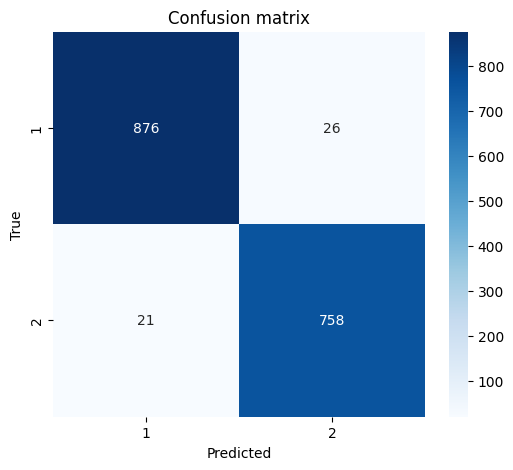

Classification report:

              precision    recall  f1-score   support

     Class 1       0.98      0.97      0.97       902
     Class 2       0.97      0.97      0.97       779

    accuracy                           0.97      1681
   macro avg       0.97      0.97      0.97      1681
weighted avg       0.97      0.97      0.97      1681



In [43]:
# ===== Matriz de confusão / Confusion matrix =====
# Previsões / Predictions
# For Decision Tree, predict directly gives the predicted class labels
y_pred_labels = model.predict(X_test)

# Matriz / Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_encoded), # Use encoded labels for xticks/yticks
            yticklabels=np.unique(y_encoded)) # since the model predicts encoded labels
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.show()

# ===== Relatório de classificação / classification report =====
print("Classification report:\n")
print(classification_report(y_test_labels, y_pred_labels, target_names=[f"Class {c}" for c in np.unique(y_encoded)])) # Use encoded labels for target_names

In [48]:
# ===== Validação Cruzada K-Fold / K-Fold Cross-Validation =====
n_splits = 5 # You can change this number

# Define the KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation
X_full = scaler.fit_transform(df.iloc[:, 1:].values) # Re-scale the full feature set
y_full_encoded = label_encoder.fit_transform(df.iloc[:, 0].values) # Re-encode the full target set

cv_scores = cross_val_score(model, X_full, y_full_encoded, cv=kf)

# Print the cross-validation scores
print(f"Cross-validation scores (accuracy) for each fold: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation of cross-validation accuracy: {cv_scores.std():.4f}")

Cross-validation scores (accuracy) for each fold: [0.97560976 0.9738251  0.97263534 0.97560976 0.975     ]
Mean cross-validation accuracy: 0.9745
Standard deviation of cross-validation accuracy: 0.0012


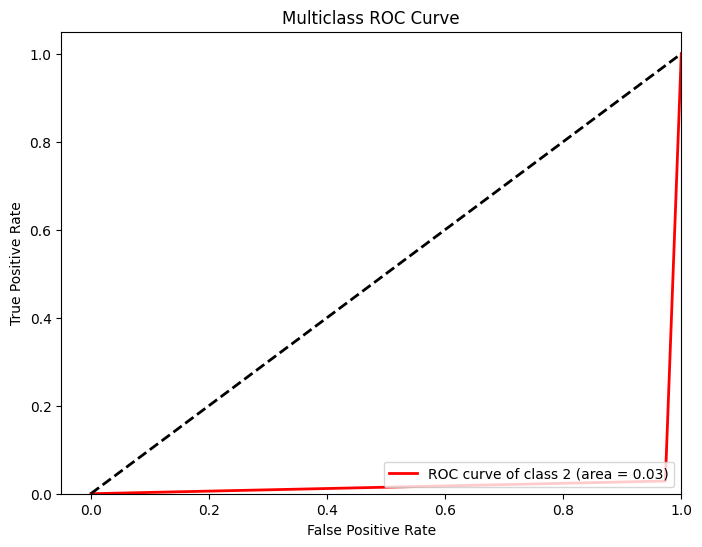

In [44]:
# Use curvas individuais (multiclass ROC) quando quiser analisar o desempenho do modelo em cada classe separadamente. / Use curvas individuais (ROC multiclasse) quando quiser analisar o desempenho do modelo em cada classe separadamente.

# Fit LabelEncoder to the original unique classes / Ajustar LabelEncoder às classes originais exclusivas
label_encoder = LabelEncoder()
label_encoder.fit(np.unique(y))

# Get predicted probabilities for ROC curve / Obter probabilidades previstas para a curva ROC
y_pred_proba = model.predict_proba(X_test)


# Compute ROC curve and ROC area for each class / Calcular a curva ROC e a área ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()

unique_classes = np.unique(y)  # Use original unique classes for labeling / Use classes originais exclusivas para rotulagem
n_classes = len(unique_classes)

for i in range(n_classes):
    class_value = unique_classes[i]
    # Use label_encoder to get the correct index for the current class / Use label_encoder para obter o índice correto para a classe atual
    class_index = label_encoder.transform([class_value])[0]

    # Check if the current class is present in the test set / Verifique se a classe atual está presente no conjunto de teste
    if np.sum(y_test[:, class_index]) > 0:
        fpr[i], tpr[i], _ = roc_curve(y_test[:, class_index], y_pred_proba[:, class_index])
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        # If a class is not in the test set, set AUC to NaN and skip plotting its curve / Se uma classe não estiver no conjunto de teste, defina AUC como NaN e pule a plotagem de sua curva
        roc_auc[i] = np.nan
        print(f"Warning: Class {class_value} has no positive samples in the test set. Skipping ROC curve for this class.")


# Plot ROC curves / Traçar curvas ROC
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i in range(n_classes):
    # Only plot if the AUC was calculated (class was in the test set) / Somente plote se a AUC foi calculada (a classe estava no conjunto de teste)
    if not np.isnan(roc_auc[i]):
        # Ensure there are enough colors / Certifique-se de que há cores suficientes
        color = colors[i % len(colors)]
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(unique_classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

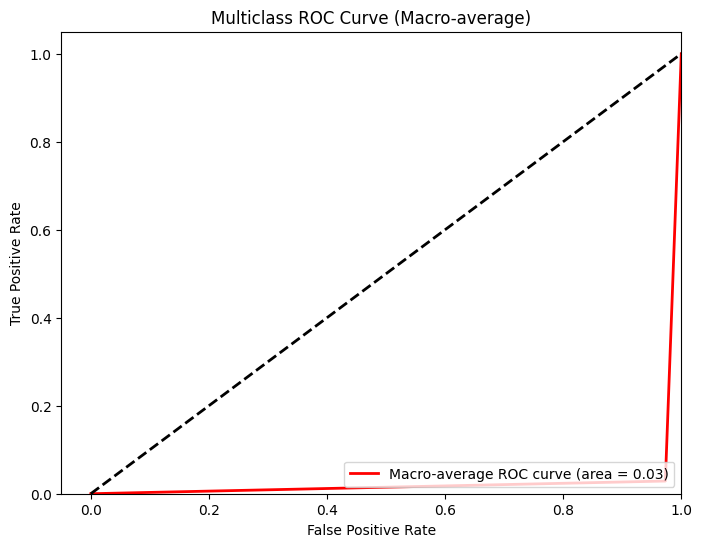

In [45]:
# Use macro-average ROC quando quiser uma visão geral do desempenho do modelo em todas as classes, sem considerar desequilíbrio entre elas. / Use ROC macro-médio quando quiser uma visão geral do desempenho do modelo em todas as classes, sem considerar desequilíbrio entre elas.

# Calculate macro-average ROC curve and AUC / Calcular a curva ROC macromédia e a AUC
# First aggregate all false positive rates / Primeiro, agregue todas as taxas de falsos positivos
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes) if not np.isnan(roc_auc[i])]))

# Then interpolate all ROC curves at this points / Em seguida, interpole todas as curvas ROC nesses pontos
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    if not np.isnan(roc_auc[i]):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC / Calcule a média e a AUC
mean_tpr /= sum([not np.isnan(roc_auc[i]) for i in range(n_classes)]) # Divide by the number of classes that were in the test set/ Divida pelo número de classes que estavam no conjunto de teste

macro_roc_auc = auc(all_fpr, mean_tpr)

# Plot macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(all_fpr, mean_tpr, color='red', linestyle='-', linewidth=2,
         label='Macro-average ROC curve (area = {0:0.2f})'.format(macro_roc_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Macro-average)')
plt.legend(loc="lower right")
plt.show()